# Background: neural cellular automata

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
import torchvision

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

## Goal: match this style with nca

In [ ]:
def download_image(url):
    image_blob = fc.urlread(url, decode=False)
    image = torchvision.io.decode_image(torch.tensor(list(image_blob), dtype=torch.uint8)) 
    return TF.resize(image, (256, 256), antialias=False).to(torch.float32) / 255.

In [ ]:
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Spider_Cobweb_%28blue%29.jpg/519px-Spider_Cobweb_%28blue%29.jpg"

In [ ]:
style_image = download_image(style_url).to(def_device)

## Style loss

In [ ]:
import timm

In [ ]:
vgg16 = timm.create_model("vgg16", True).features.to(def_device)

In [ ]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).to(def_device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).to(def_device)
imagenet_mean = imagenet_mean[:, None, None]
imagenet_std = imagenet_std[:, None, None]

In [ ]:
def normalize(im):
    return (im - imagenet_mean) / imagenet_std

In [ ]:
def calc_features(imgs, target_layers=(18,25)):
    imgs = normalize(imgs)
    result = []
    last_layer = max(target_layers) + 1
    for i, layer in enumerate(vgg16[:last_layer]):
        imgs = layer(imgs)
        if i in target_layers:
            result.append(imgs)

    return result

In [ ]:
def calc_grams(img, target_layers=(1,6,11,18,25)):
    features = calc_features(img, target_layers)
    result = []
    for feat in features:  # khw -> k^2
        result.append(
            # torch.einsum("bahw,bchw->bac", feat, feat) * (1 / feat.shape[-1] / feat.shape[-2])
            torch.einsum("bahw,bchw->ac", feat, feat) * (1 / feat.shape[-1] / feat.shape[-2])
        )

    return result

In [ ]:
class StyleLossToTarget(nn.Module):
    def __init__(self, target_im, target_layers=(1,6,11,18,25)):
        super().__init__()
        with torch.no_grad():
            self.target = calc_grams(target_im[None], target_layers)
        self.target_layers = target_layers

    def __call__(self, x):
        grams = calc_grams(x, self.target_layers)
        loss = 0
        for i, g in enumerate(grams):
            loss += F.mse_loss(g, self.target[i])
        return loss

In [ ]:
style_loss = StyleLossToTarget(style_image)

## Defining the NCA model

In [ ]:
num_channels = 4
hidden_n = 8

In [ ]:
def make_grids(n, sz=128):
    return torch.zeros(n, num_channels, sz, sz, device=def_device)

In [ ]:
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
])[:, None].to(def_device)
filters.shape

torch.Size([4, 1, 3, 3])

In [ ]:
F.pad?

Docstring:
pad(input, pad, mode="constant", value=None) -> Tensor

Pads tensor.

Padding size:
    The padding size by which to pad some dimensions of :attr:`input`
    are described starting from the last dimension and moving forward.
    :math:`\left\lfloor\frac{\text{len(pad)}}{2}\right\rfloor` dimensions
    of ``input`` will be padded.
    For example, to pad only the last dimension of the input tensor, then
    :attr:`pad` has the form
    :math:`(\text{padding\_left}, \text{padding\_right})`;
    to pad the last 2 dimensions of the input tensor, then use
    :math:`(\text{padding\_left}, \text{padding\_right},`
    :math:`\text{padding\_top}, \text{padding\_bottom})`;
    to pad the last 3 dimensions, use
    :math:`(\text{padding\_left}, \text{padding\_right},`
    :math:`\text{padding\_top}, \text{padding\_bottom}`
    :math:`\text{padding\_front}, \text{padding\_back})`.

Padding mode:
    See :class:`torch.nn.CircularPad2d`, :class:`torch.nn.ConstantPad2d`,
    :class:`torch

In [ ]:
F.conv2d?

Docstring:
conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor

Applies a 2D convolution over an input image composed of several input
planes.

This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.

See :class:`~torch.nn.Conv2d` for details and output shape.

Note:
    In some circumstances when given tensors on a CUDA device and using CuDNN, this operator may select a nondeterministic algorithm to increase performance. If this is undesirable, you can try to make the operation deterministic (potentially at a performance cost) by setting ``torch.backends.cudnn.deterministic = True``. See :doc:`/notes/randomness` for more information.

Note:
    This operator supports complex data types i.e. ``complex32, complex64, complex128``.


Args:
    input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
    weight: filters of shape :math:`(\text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW)`
    bias

In [ ]:
def perchannel_conv(x, filters):
    b, c, h, w = x.shape
    x = x.reshape(b*c, 1, h, w)
    x = F.pad(x, [1, 1, 1, 1], "circular")
    x = F.conv2d(input=x, weight=filters)
    x = x.reshape(b, -1, h, w)
    return x

In [ ]:
x = make_grids(1)
perchannel_conv(x, filters).shape

torch.Size([1, 16, 128, 128])

In [ ]:
brain = nn.Sequential(
    nn.Linear(num_channels * 4, hidden_n),
    nn.ReLU(),
    nn.Linear(hidden_n, num_channels)
).to(def_device)
inputs = perchannel_conv(x, filters)
inputs_flat = inputs.reshape(-1, inputs.shape[1])
preds = brain(inputs_flat).reshape(x.shape)
preds.shape

torch.Size([1, 4, 128, 128])

In [ ]:
brain = nn.Sequential(
    nn.Conv2d(num_channels * 4, hidden_n, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(hidden_n, num_channels, kernel_size=1)
).to(def_device)
preds = brain(inputs)
preds.shape

torch.Size([1, 4, 128, 128])

In [ ]:
init.zeros_?

Signature: init.zeros_(tensor: torch.Tensor) -> torch.Tensor
Docstring:
Fills the input Tensor with the scalar value `0`.

Args:
    tensor: an n-dimensional `torch.Tensor`

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.zeros_(w)
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torch/nn/init.py
Type:      function

In [ ]:
dist = torch.distributions.bernoulli.Bernoulli(probs=0.5)
t = dist.sample(x.shape)
t.mean(), t.shape

(tensor(0.5020), torch.Size([1, 4, 128, 128]))

In [ ]:
 class SimpleCA(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.brain = nn.Sequential(
            nn.Conv2d(num_channels * 4, hidden_n, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_n, num_channels, kernel_size=1, bias=False)
        )
        if zero_w2:
            self.brain[-1].weight.data.zero_()

    def forward(self, x, update_rate=0.5):
        new = perchannel_conv(x, filters)
        new = self.brain(new)
        b, _, h, w = new.shape

        dist = torch.distributions.bernoulli.Bernoulli(probs=update_rate)
        mask = dist.sample((b,1,h,w)).to(def_device)
        x = x + new * mask
        return x

    def to_rgb(self, x):
        return x[:, :3, :, :] + 0.5     

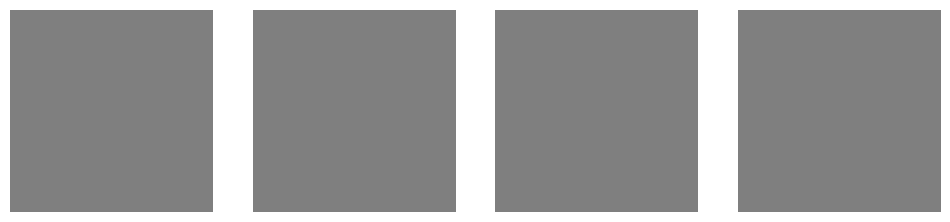

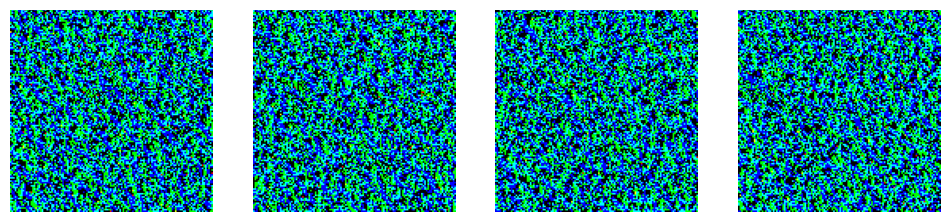

In [ ]:
set_seed(1103, False)
model = SimpleCA(False).to(def_device)
x = make_grids(4)
show_images(model.to_rgb(x), nrows=1)
with torch.no_grad():
    for i in range(25):
        x = model(x)
show_images(model.to_rgb(x).clip(0, 1), nrows=1)
del model; del x

## Training

In [ ]:
class LengthDataset:
    def __init__(self, len):
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return 0, 0

In [ ]:
def get_dummy_dls(len):
    return DataLoaders(
        DataLoader(LengthDataset(len)),
        DataLoader(LengthDataset(1))
    )

In [ ]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.4f}"
        if hasattr(learn, "metrics") and learn.training:
            self.losses.append(to_cpu(learn.loss).item())
            
            if (learn.batch_idx % self.update_rate) == 0:
                self._update_preview(learn)

    def after_fit(self, learn):
        self._update_preview(learn)


    def _update_preview(self, learn):
        progress_bar = learn.range_epochs
        if not hasattr(progress_bar, "graph_fig"):
            progress_bar.graph_fig, progress_bar.graph_axs = plt.subplots(1, 2, figsize=(15, 6))
            progress_bar.graph_out = display(progress_bar.graph_fig, display_id=True)

        show_image(
            torchvision.utils.make_grid(
                learn.model.to_rgb(to_cpu(learn.preds)).clip(0, 1)
            ),
            ax=progress_bar.graph_axs[1]
        )

        progress_bar.graph_axs[0].clear()
        progress_bar.graph_axs[0].plot(self.losses, marker=".", lw=0.1)
        progress_bar.graph_axs[0].set_yscale("log")
        bottom, top = progress_bar.graph_axs[0].get_ylim()
        progress_bar.graph_axs[0].set_ylim(top=min(3*self.losses[0], top))
        progress_bar.graph_axs[0].hlines(min(self.losses), 0, len(self.losses), color="black")
        
        progress_bar.graph_out.update(progress_bar.graph_fig)

In [ ]:
class NCACB(TrainCB):
    order = DeviceCB.order + 1

    def __init__(
        self, style_loss_scale=0.1,
        size=256, step_n_min=32, step_n_max=96,
        n_grids=256, grids_per_update=8, chance_to_zero=1/16, grad_norm=True,
    ):
        fc.store_attr()
        self.pool = make_grids(n_grids, sz=size)
        self.countasd=0

    def predict(self, learn):
        indices = torch.randint(0, self.n_grids, (self.grids_per_update,))
        batch = self.pool[indices]
        to_reinit = torch.rand(self.grids_per_update) < self.chance_to_zero
        # batch[to_reinit] = 0.
        if to_reinit.any():
            batch[to_reinit] = torch.randn(1, num_channels, self.size, self.size, device=def_device) * 0.01

        steps = torch.randint(self.step_n_min, self.step_n_max, (1,))
        for step in steps:
            batch = learn.model(batch)

        with torch.no_grad():
            self.pool[indices] = batch
        learn.preds = batch

    def get_loss(self, learn):
        overflow = (learn.preds - learn.preds.clamp(0.0, 1.0)).abs().sum()
        # overflow = 0.
        learn.loss = overflow + self.style_loss_scale * learn.loss_func(learn.model.to_rgb(learn.preds))

    def backward(self, learn):
        super().backward(learn)
        if self.grad_norm:
            for p in learn.model.parameters():
                p.grad /= p.grad.norm() + 1e-6

In [ ]:
set_seed(1103, False)
steps = 1024
lr = 0.001
model = SimpleCA().to(def_device)
cbs = [NCACB(), NCAProgressCB(update_rate=128), MetricsCB(), DeviceCB()]
style_loss = StyleLossToTarget(style_image)
learn = Learner(model, get_dummy_dls(steps), style_loss, lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

In [ ]:
show_image(
    torchvision.utils.make_grid(
        learn.model.to_rgb(to_cpu(learn.preds)).clip(0, 1)
    )
);
show_image(style_image);

In [ ]:
x = torch.randn(1, num_channels, 64, 64).to(def_device) * 0.01
to_show = []
with torch.no_grad():
    for step in range(1201):
        x = model(x)
        if step % 100 == 99:
            to_show.append(learn.model.to_rgb(to_cpu(x))[0].clip(0, 1))
show_images(to_show);

In [ ]:
model.brain[0].weight.shape, model.brain[2].weight.shape

In [ ]:
print(model.brain[0].weight.data.reshape(4,32))
print(model.brain[0].bias.data)
print(model.brain[2].weight.data.reshape(8, 4))

### using the image from the lesson

In [ ]:
style_image = download_image("https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256").to(def_device)
set_seed(1103, False)
steps = 1200
lr = 0.001
model = SimpleCA().to(def_device)
cbs = [NCACB(grids_per_update=4, chance_to_zero=1/8, size=256, n_grids=256), NCAProgressCB(update_rate=60), MetricsCB(), DeviceCB()]
style_loss = StyleLossToTarget(style_image)
learn = Learner(model, get_dummy_dls(steps), style_loss, lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

In [ ]:
show_image(
    torchvision.utils.make_grid(
        learn.model.to_rgb(to_cpu(learn.preds)).clip(0, 1)
    )
);
show_image(style_image);

In [ ]:
x = torch.randn(1, num_channels, 64, 64).to(def_device) * 0.01
to_show = []
with torch.no_grad():
    for step in range(1201):
        x = model(x)
        if step % 100 == 99:
            to_show.append(learn.model.to_rgb(to_cpu(x))[0].clip(0, 1))
show_images(to_show);

In [ ]:
sum(p.numel() for p in model.parameters())

168

In [ ]:
print(model.brain[0].weight.data.reshape(4,32))
print(model.brain[0].bias.data)
print(model.brain[2].weight.data.reshape(8, 4))

In [ ]:
style_image = download_image("https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256").to(def_device)
set_seed(1103, False)
steps = 600
lr = 0.01
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=steps))
model = SimpleCA().to(def_device)
cbs = [NCACB(), NCAProgressCB(update_rate=50), MetricsCB(), DeviceCB(), sched]
style_loss = StyleLossToTarget(style_image)
learn = Learner(model, get_dummy_dls(steps), style_loss, lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

In [ ]:
show_image(
    torchvision.utils.make_grid(
        learn.model.to_rgb(to_cpu(learn.preds)).clip(0, 1)
    )
);
show_image(style_image);

In [ ]:
x = torch.randn(1, num_channels, 64, 64).to(def_device) * 0.01
to_show = []
with torch.no_grad():
    for step in range(1201):
        x = model(x)
        if step % 100 == 99:
            to_show.append(learn.model.to_rgb(to_cpu(x))[0].clip(0, 1))
show_images(to_show);

In [ ]:
print(model.brain[0].weight.data.reshape(4,32))
print(model.brain[0].bias.data)
print(model.brain[2].weight.data.reshape(8, 4))